<a href="https://colab.research.google.com/github/ritikarana9999/PatternAnalysis-2023/blob/main/ADNI_Brain_Visual_Transformer_47306725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: RITIKA RANA

Student ID: 47306725

Email: r.rana@uqconnect.edu.au


In [ ]:
pip install tensorflow_addons


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers
import math

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
test_ = zipfile.ZipFile(file = '/content/drive/MyDrive/test.zip',mode = 'r')
test_.extractall('./')
test_.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/test.zip' mode='r'>>

In [ ]:
train_ = zipfile.ZipFile(file = '/content/drive/MyDrive/train.zip',mode = 'r')
train_.extractall('./')
train_.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/train.zip' mode='r'>>

MODEL 1


Parameters

In [ ]:
# Hyperparameters
IMG_SIZE = 128
PATCH_SIZE = 8
BATCH_SIZE = 32
EPOCHS = 10
WEIGHT_DECAY = 0.0001
PROJECTION_DIM = 512 # MLP-blocks depth
LEARN_RATE = 0.0005
TRANSF_LAYERS = 5 # No. of transformer-encoder-blocks
DROPOUT_RATE = 0.2
ATTENTION_HEADS = 5
MLP_HEAD_UNITS = [256, 128]
DATA_LOAD_DEST = "/content"
MODEL_SAVE_DEST = "/content/vision_transformer"



In [ ]:
#Calculating automat
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
HIDDEN_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
NUM_PATCHES = int((IMG_SIZE/PATCH_SIZE) ** 2)

Dataset

In [ ]:
def loadData():
    """
    Loading the dataset.
    """
    trainData = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_LOAD_DEST + "/train", labels='inferred', label_mode='binary',
        image_size=[IMG_SIZE, IMG_SIZE], shuffle=True,
        batch_size=BATCH_SIZE, seed=8, class_names=['AD', 'NC']
    )

    testData = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_LOAD_DEST + "/test", labels='inferred', label_mode='binary',
        image_size=[IMG_SIZE, IMG_SIZE], shuffle=True,
        batch_size=BATCH_SIZE, seed=8, class_names=['AD', 'NC']
    )

    # Augmenting data
    normalize = tf.keras.layers.Normalization()
    flip = tf.keras.layers.RandomFlip(mode='horizontal', seed=8)
    rotate = tf.keras.layers.RandomRotation(factor=0.02, seed=8)
    zoom = tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1, seed=8)

    trainData = trainData.map(
        lambda x, y: (rotate(flip(zoom(normalize(x)))), y)
    )

    testData = testData.map(
        lambda x, y: (rotate(flip(zoom(normalize(x)))), y)
    )

    # Taking half of the 9000 images from the test set as validation data
    validationData = testData.take(len(list(testData))//2)

    # Using remaining images as test set
    testData = testData.skip(len(list(testData))//2)

    return trainData, validationData, testData

Modules

In [ ]:
class PatchLayer(Layer):
	"""
	Layering and transforming images into patches.
	"""
	def __init__(self, img_size, patch_size, num_patches, projection_dim, **kwargs):
		super(PatchLayer, self).__init__(**kwargs)
		self.img_size = img_size
		self.patch_size = patch_size
		self.num_patches = num_patches
		self.projection_dim = projection_dim
		self.half_patch = patch_size // 2
		self.flatten_patches = layers.Reshape((num_patches, -1))
		self.projection = layers.Dense(units=projection_dim)
		self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

	def shiftImg(self, images, mode):
		# Building diagonally-shifted images
		if mode == 'left-up':
			cropheight = self.half_patch
			cropwidth = self.half_patch
			shiftheight = 0
			shiftwidth = 0
		elif mode == 'left-down':
			cropheight = 0
			cropwidth = self.half_patch
			shiftheight = self.half_patch
			shiftwidth = 0
		elif mode == 'right-up':
			cropheight = self.half_patch
			cropwidth = 0
			shiftheight = 0
			shiftwidth = self.half_patch
		else:
			cropheight = 0
			cropwidth = 0
			shiftheight = self.half_patch
			shiftwidth = self.half_patch

		crop = tf.image.crop_to_bounding_box(
			images,
			offset_height=cropheight,
			offset_width=cropwidth,
			target_height=self.img_size - self.half_patch,
			target_width=self.img_size - self.half_patch
		)

		shiftPad = tf.image.pad_to_bounding_box(
			crop,
			offset_height=shiftheight,
			offset_width=shiftwidth,
			target_height=self.img_size,
			target_width=self.img_size
		)
		return shiftPad

	def call(self, images):
		images = tf.concat(
			[
				images,
				self.shiftImg(images, mode='left-up'),
				self.shiftImg(images, mode='left-down'),
				self.shiftImg(images, mode='right-up'),
				self.shiftImg(images, mode='right-down'),
			],
			axis=-1
		)
		patches = tf.image.extract_patches(
			images=images,
			sizes=[1, self.patch_size, self.patch_size, 1],
			strides=[1, self.patch_size, self.patch_size, 1],
			rates=[1, 1, 1, 1],
			padding='VALID'
		)
		flat_patches = self.flatten_patches(patches)
		tokens = self.layer_norm(flat_patches)
		tokens = self.projection(tokens)

		return (tokens, patches)

	def getConfig_(self):
		config_ = super(PatchLayer, self).getConfig_()
		config_.update(
			{
				'img_size': self.img_size,
				'patch_size': self.patch_size,
				'num_patches': self.num_patches,
				'projection_dim': self.projection_dim
			}
		)
		return config_

In [ ]:
class Embed_Patch(Layer):
	"""
	Layering for projecting patches into a vector.
	"""
	def __init__(self, num_patches, projection_dim, **kwargs):
		super(Embed_Patch, self).__init__(**kwargs)
		self.num_patches = num_patches
		self.projection_dim = projection_dim
		self.position_embedding = layers.Embedding(
			input_dim=self.num_patches, output_dim=projection_dim
		)

	def call(self, patches):
		positions = tf.range(0, self.num_patches, delta=1)
		return patches + self.position_embedding(positions)

	def getConfig_(self):
		config_ = super(Embed_Patch, self).getConfig_()
		config_.update(
			{
				'num_patches': self.num_patches,
				'projection_dim': self.projection_dim
			}
		)
		return config_

In [ ]:
class Multi_Head_AttentionLSA(layers.MultiHeadAttention):
	"""
	Multi Head Attention layer for the transformer-encoder block, but with the
	addition of using Local-Self-Attention to improve feature	learning.

	"""
	def __init__(self, **kwargs):
		super(Multi_Head_AttentionLSA, self).__init__(**kwargs)
		self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

	def computeAttention(self, query, key, value, attention_mask=None,
			training=None):
		query = tf.multiply(query, 1.0/self.tau)
		attention_scores = tf.einsum(self._dot_product_equation, key, query)
		attention_mask = tf.convert_to_tensor(attention_mask)
		attention_scores = self._masked_softmax(attention_scores, attention_mask)
		attention_scores_dropout = self._dropout_layer(
			attention_scores, training=training
		)
		attention_output = tf.einsum(
			self._combine_equation, attention_scores_dropout, value
		)
		return attention_output, attention_scores

	def getConfig_(self):
		config_ = super(Multi_Head_AttentionLSA, self).getConfig_()
		return config_


def buildVisionTransformer(input_shape, img_size, patch_size, num_patches,
			attention_heads, projection_dim, hidden_units, dropout_rate,
			transf_layers, mlp_head_units):
	"""
	Building the vision transformer.
	"""
	# Input layer
	inputs = layers.Input(shape=input_shape)

	# Convert image data into patches
	(tokens, _) = PatchLayer(
		img_size,
		patch_size,
		num_patches,
		projection_dim
	)(inputs)

	# Encode patches
	encodedPatches = Embed_Patch(num_patches, projection_dim)(tokens)

	# Create transformer layers
	for _ in range(transf_layers):
		# First layer normalisation
		layerNorm1 = layers.LayerNormalization(
			epsilon=1e-6
		)(encodedPatches)

		# Build diagoanl attention mask
		diagAttnMask = 1 - tf.eye(num_patches)
		diagAttnMask = tf.cast([diagAttnMask], dtype=tf.int8)

		# Multi-head attention layer
		attention_output = Multi_Head_AttentionLSA(
			num_heads=attention_heads, key_dim=projection_dim,
			dropout=dropout_rate
		)(layerNorm1, layerNorm1, attention_mask=diagAttnMask)

		# First skip connection
		skip1 = layers.Add()([attention_output, encodedPatches])

		# Second layer normalisation
		layerNorm2 = layers.LayerNormalization(epsilon=1e-6)(skip1)

		# Multi-Layer Perceptron
		mlpLayer = layerNorm2
		for units in hidden_units:
			mlpLayer = layers.Dense(units, activation=tf.nn.gelu)(mlpLayer)
			mlpLayer = layers.Dropout(dropout_rate)(mlpLayer, training=False)

		# Second skip connection
		encodedPatches = layers.Add()([mlpLayer, skip1])

	# Create a [batch_size, projection_dim] tensor
	representtn = layers.LayerNormalization(epsilon=1e-6)(encodedPatches)
	representtn = layers.Flatten()(representtn)
	representtn = layers.Dropout(dropout_rate)(representtn, training=False)

	# MLP layer for learning features
	features = representtn
	for units in mlp_head_units:
		features = layers.Dense(units, activation=tf.nn.gelu)(features)
		features = layers.Dropout(dropout_rate)(features, training=False)

	# Classify outputs
	logits = layers.Dense(1)(features)

	# Create Keras model
	model = tf.keras.Model(inputs=inputs, outputs=logits)

	return model


Train

In [ ]:
def compileModel():
    """
    compiles the model.
    """
    # Build and compile model
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARN_RATE,
        weight_decay=WEIGHT_DECAY
    )

    model = buildVisionTransformer(
        INPUT_SHAPE,
        IMG_SIZE,
        PATCH_SIZE,
        NUM_PATCHES,
        ATTENTION_HEADS,
        PROJECTION_DIM,
        HIDDEN_UNITS,
        DROPOUT_RATE,
        TRANSF_LAYERS,
        MLP_HEAD_UNITS
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy')
        ]
    )

    return model


def trainModel(model, trainData, val_data):
    """
    Trains and saves the model.
    """

    # Train model
    history = model.fit(
        x=trainData,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_data
    )

    # Save model
    model.save(
        MODEL_SAVE_DEST,
        overwrite=True,
        include_optimizer=True,
        save_format='tf'
    )

    # Plot and save accuracy curves
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.suptitle('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.savefig('accuracy.png')
    plt.clf()

    # Plot and save loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.suptitle('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.savefig('losses.png')
    plt.clf()


if __name__ == '__main__':
    # Load data
    train, val, test = loadData()

    # Compile and train model
    model = compileModel()
    print(model.summary())
    trainModel(model, train, val)

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 patch_layer (PatchLayer)    ((None, 256, 512),           493952    ['input_1[0][0]']             
                              (None, 16, 16, 960))                                                
                                                                                                  
 embed__patch (Embed_Patch)  (None, 256, 512)             131072    ['patch_layer[0][0]']         
                                                                                                  
 layer_norm

673/673 [==============================] - 538s 783ms/step - loss: 1.3290 - accuracy: 0.5515 - val_loss: 0.7497 - val_accuracy: 0.5199
Epoch 2/10
673/673 [==============================] - 532s 791ms/step - loss: 0.6585 - accuracy: 0.5887 - val_loss: 0.7390 - val_accuracy: 0.5148
Epoch 3/10
673/673 [==============================] - 528s 785ms/step - loss: 0.6184 - accuracy: 0.6322 - val_loss: 0.7304 - val_accuracy: 0.5780
Epoch 4/10
673/673 [==============================] - 528s 784ms/step - loss: 0.5843 - accuracy: 0.6649 - val_loss: 0.7581 - val_accuracy: 0.5477
Epoch 5/10
673/673 [==============================] - 527s 783ms/step - loss: 0.5607 - accuracy: 0.6953 - val_loss: 0.7644 - val_accuracy: 0.5727
Epoch 6/10
673/673 [==============================] - 526s 782ms/step - loss: 0.5645 - accuracy: 0.6891 - val_loss: 0.7315 - val_accuracy: 0.5720
Epoch 7/10
673/673 [==============================] - 526s 782ms/step - loss: 0.5570 - accuracy: 0.6960 - val_loss: 0.7427 - val_accura

<Figure size 640x480 with 0 Axes>

Predict

In [ ]:
def predict(load_path, testData):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARN_RATE,
        weight_decay=WEIGHT_DECAY
    )

    model = tf.keras.models.load_model(
        load_path,
        custom_objects={
            'PatchLayer': PatchLayer,
            'Embed_Patch': Embed_Patch,
            'MultiheadattentionLSA': Multi_Head_AttentionLSA,
            'AdamW': optimizer
        }
    )

    model.evaluate(testData)

    # Plot confusion matrix
    y_true = []
    y_pred = []

    for image_batch, label_batch in testData:
        y_true.append(label_batch)
        y_pred.append((model.predict(image_batch, verbose=0) > 0.5).astype('int32'))

    labels_true = tf.concat([tf.cast(item[0], tf.int32) for item in y_true], axis=0)
    labels_pred = tf.concat([item[0] for item in y_pred], axis=0)

    matrix = tf.math.confusion_matrix(labels_true, labels_pred, 2).numpy()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(x=j, y=i, s=matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actual Label', fontsize=18)
    plt.suptitle('Confusion Matrix', fontsize=18)
    plt.savefig('confusion_matrix')
    plt.clf()


if __name__ == '__main__':
    train, val, test = loadData()
    predict(MODEL_SAVE_DEST, test)

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
141/141 [==============================] - 61s 258ms/step - loss: 0.7488 - accuracy: 0.5541


<Figure size 800x800 with 0 Axes>

utils

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.


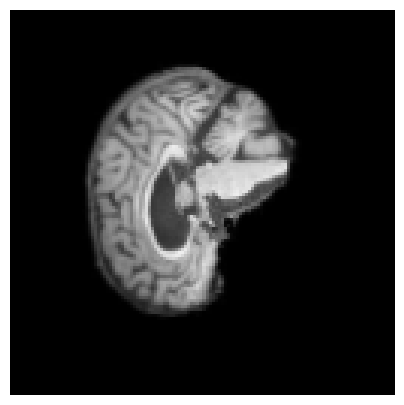

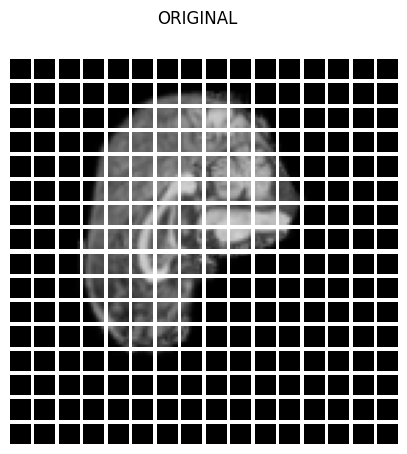

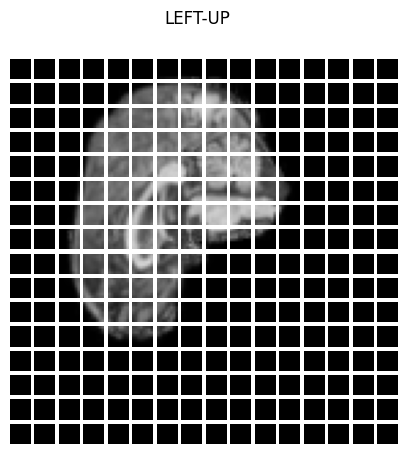

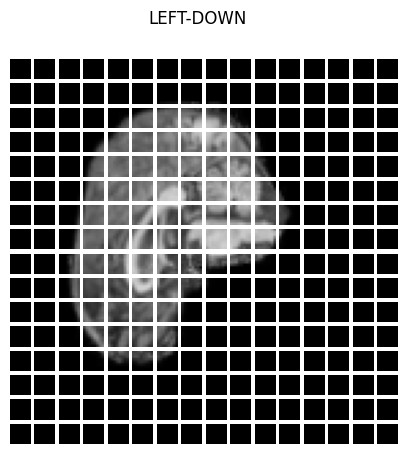

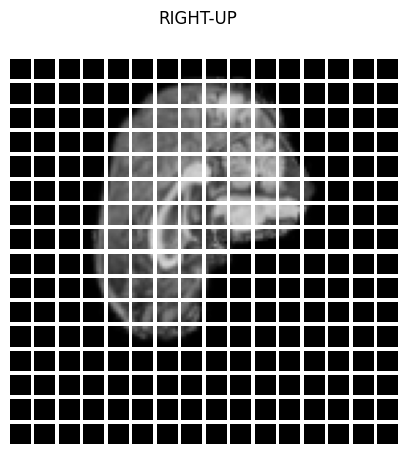

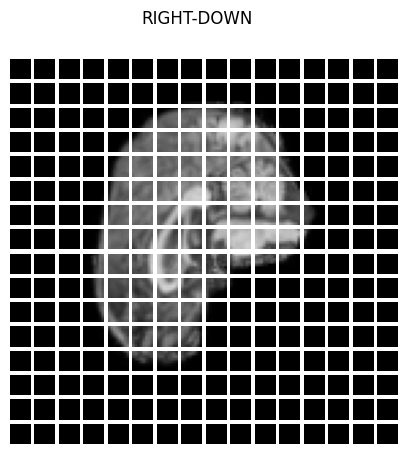

In [ ]:
def plot_image(dataset):
    """
    Ploting image from the given dataset.
    """
    plt.figure(figsize=(5, 5))
    datasetIt = dataset.__iter__()
    image = datasetIt.next()[0][0]
    plt.imshow(image.numpy().astype('uint8'))
    plt.axis('off')
    plt.show()


def plot_patches(dataset):
    """
    Ploting image from the given dataset after applying Patch_Layer to it.
    """
    datasetIt = dataset.__iter__()
    image = datasetIt.next()[0][0]

    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(IMG_SIZE, IMG_SIZE)
    )

    (token, patch) = PatchLayer(IMG_SIZE, PATCH_SIZE, NUM_PATCHES, PROJECTION_DIM)(resized_image/255.0)
    (token, patch) = (token[0], patch[0])
    n = patch.shape[0]
    shiftedImg = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]

    for index, name in enumerate(shiftedImg):
        count = 1
        plt.figure(figsize=(5, 5))
        plt.suptitle(name)

        for row in range(n):
            for col in range(n):
                plt.subplot(n, n, count)
                count = count + 1
                image= tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3 * 5))
                plt.imshow(image[..., 3 * index : 3 * index + 3])
                plt.axis('off')

    plt.show()


if __name__ == '__main__':
    train, val, test = loadData()
    plot_image(train)
    plot_patches(train)

MODEL 2


In [ ]:
# Hyperparameters
IMG_SIZE = 128
PATCH_SIZE = 8
BATCH_SIZE = 32
EPOCHS = 10
WEIGHT_DECAY = 0.0001
PROJECTION_DIM = 128 # MLP-blocks depth
LEARN_RATE = 0.001
TRANSF_LAYERS = 3 # No. of transformer-encoder-blocks
DROPOUT_RATE = 0.4
ATTENTION_HEADS = 5
MLP_HEAD_UNITS = [64, 32]
DATA_LOAD_DEST = "/content"
MODEL_SAVE_DEST = "/content/vision_transformer"

#Calculating automat
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
HIDDEN_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
NUM_PATCHES = int((IMG_SIZE/PATCH_SIZE) ** 2)

In [ ]:
def loadData():
    """
    Loading the dataset.
    """
    trainData = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_LOAD_DEST + "/train", labels='inferred', label_mode='binary',
        image_size=[IMG_SIZE, IMG_SIZE], shuffle=True,
        batch_size=BATCH_SIZE, seed=8, class_names=['AD', 'NC']
    )

    testData = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_LOAD_DEST + "/test", labels='inferred', label_mode='binary',
        image_size=[IMG_SIZE, IMG_SIZE], shuffle=True,
        batch_size=BATCH_SIZE, seed=8, class_names=['AD', 'NC']
    )

    # Augment data
    normalize = tf.keras.layers.Normalization()
    flip = tf.keras.layers.RandomFlip(mode='horizontal', seed=8)
    rotate = tf.keras.layers.RandomRotation(factor=0.02, seed=8)
    zoom = tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1, seed=8)

    trainData = trainData.map(
        lambda x, y: (rotate(flip(zoom(normalize(x)))), y)
    )

    testData = testData.map(
        lambda x, y: (rotate(flip(zoom(normalize(x)))), y)
    )

    # Taking half of the 9000 images from the test set as validation data
    validationData = testData.take(len(list(testData))//2)

    # Using remaining images as test set
    testData = testData.skip(len(list(testData))//2)

    return trainData, validationData, testData

In [ ]:
class PatchLayer(Layer):
	"""
	Layering and transforming images into patches.
	"""
	def __init__(self, img_size, patch_size, num_patches, projection_dim, **kwargs):
		super(PatchLayer, self).__init__(**kwargs)
		self.img_size = img_size
		self.patch_size = patch_size
		self.num_patches = num_patches
		self.projection_dim = projection_dim
		self.half_patch = patch_size // 2
		self.flatten_patches = layers.Reshape((num_patches, -1))
		self.projection = layers.Dense(units=projection_dim)
		self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

	def shiftImg(self, images, mode):
		# Build diagonally shifted images
		if mode == 'left-up':
			cropheight = self.half_patch
			cropwidth = self.half_patch
			shiftheight = 0
			shiftwidth = 0
		elif mode == 'left-down':
			cropheight = 0
			cropwidth = self.half_patch
			shiftheight = self.half_patch
			shiftwidth = 0
		elif mode == 'right-up':
			cropheight = self.half_patch
			cropwidth = 0
			shiftheight = 0
			shiftwidth = self.half_patch
		else:
			cropheight = 0
			cropwidth = 0
			shiftheight = self.half_patch
			shiftwidth = self.half_patch

		crop = tf.image.crop_to_bounding_box(
			images,
			offset_height=cropheight,
			offset_width=cropwidth,
			target_height=self.img_size - self.half_patch,
			target_width=self.img_size - self.half_patch
		)

		shiftPad = tf.image.pad_to_bounding_box(
			crop,
			offset_height=shiftheight,
			offset_width=shiftwidth,
			target_height=self.img_size,
			target_width=self.img_size
		)
		return shiftPad

	def call(self, images):
		images = tf.concat(
			[
				images,
				self.shiftImg(images, mode='left-up'),
				self.shiftImg(images, mode='left-down'),
				self.shiftImg(images, mode='right-up'),
				self.shiftImg(images, mode='right-down'),
			],
			axis=-1
		)
		patches = tf.image.extract_patches(
			images=images,
			sizes=[1, self.patch_size, self.patch_size, 1],
			strides=[1, self.patch_size, self.patch_size, 1],
			rates=[1, 1, 1, 1],
			padding='VALID'
		)
		flat_patches = self.flatten_patches(patches)
		tokens = self.layer_norm(flat_patches)
		tokens = self.projection(tokens)

		return (tokens, patches)

	def getConfig_(self):
		config_ = super(PatchLayer, self).getConfig_()
		config_.update(
			{
				'img_size': self.img_size,
				'patch_size': self.patch_size,
				'num_patches': self.num_patches,
				'projection_dim': self.projection_dim
			}
		)
		return config_

In [ ]:
class Embed_Patch(Layer):
	"""
	Layer for projecting patches into a vector.
	"""
	def __init__(self, num_patches, projection_dim, **kwargs):
		super(Embed_Patch, self).__init__(**kwargs)
		self.num_patches = num_patches
		self.projection_dim = projection_dim
		self.position_embedding = layers.Embedding(
			input_dim=self.num_patches, output_dim=projection_dim
		)

	def call(self, patches):
		positions = tf.range(0, self.num_patches, delta=1)
		return patches + self.position_embedding(positions)

	def getConfig_(self):
		config_ = super(Embed_Patch, self).getConfig_()
		config_.update(
			{
				'num_patches': self.num_patches,
				'projection_dim': self.projection_dim
			}
		)
		return config_

In [ ]:
class Multi_Head_AttentionLSA(layers.MultiHeadAttention):
	"""
	Multi Head Attention layer for the transformer-encoder-block, but with the
	addition of using Local-Self-Attention to improve feature
	learning.
	"""
	def __init__(self, **kwargs):
		super(Multi_Head_AttentionLSA, self).__init__(**kwargs)
		self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

	def computeAttention(self, query, key, value, attention_mask=None,
			training=None):
		query = tf.multiply(query, 1.0/self.tau)
		attention_scores = tf.einsum(self._dot_product_equation, key, query)
		attention_mask = tf.convert_to_tensor(attention_mask)
		attention_scores = self._masked_softmax(attention_scores, attention_mask)
		attention_scores_dropout = self._dropout_layer(
			attention_scores, training=training
		)
		attention_output = tf.einsum(
			self._combine_equation, attention_scores_dropout, value
		)
		return attention_output, attention_scores

	def getConfig_(self):
		config_ = super(Multi_Head_AttentionLSA, self).getConfig_()
		return config_


def buildVisionTransformer(input_shape, img_size, patch_size, num_patches,
			attention_heads, projection_dim, hidden_units, dropout_rate,
			transf_layers, mlp_head_units):
	"""
	Building the vision transformer.
	"""
	# Input layer
	inputs = layers.Input(shape=input_shape)

	# Convert image data into patches
	(tokens, _) = PatchLayer(
		img_size,
		patch_size,
		num_patches,
		projection_dim
	)(inputs)

	# Encode patches
	encodedPatches = Embed_Patch(num_patches, projection_dim)(tokens)

	# Create transformer layers
	for _ in range(transf_layers):
		# First layer normalisation
		layerNorm1 = layers.LayerNormalization(
			epsilon=1e-6
		)(encodedPatches)

		# Build diagoanl attention mask
		diagAttnMask = 1 - tf.eye(num_patches)
		diagAttnMask = tf.cast([diagAttnMask], dtype=tf.int8)

		# Multi-head attention layer
		attention_output = Multi_Head_AttentionLSA(
			num_heads=attention_heads, key_dim=projection_dim,
			dropout=dropout_rate
		)(layerNorm1, layerNorm1, attention_mask=diagAttnMask)

		# First skip connection
		skip1 = layers.Add()([attention_output, encodedPatches])

		# Second layer normalisation
		layerNorm2 = layers.LayerNormalization(epsilon=1e-6)(skip1)

		# Multi-Layer Perceptron
		mlpLayer = layerNorm2
		for units in hidden_units:
			mlpLayer = layers.Dense(units, activation=tf.nn.gelu)(mlpLayer)
			mlpLayer = layers.Dropout(dropout_rate)(mlpLayer, training=False)

		# Second skip connection
		encodedPatches = layers.Add()([mlpLayer, skip1])

	# Create a [batch_size, projection_dim] tensor
	representtn = layers.LayerNormalization(epsilon=1e-6)(encodedPatches)
	representtn = layers.Flatten()(representtn)
	representtn = layers.Dropout(dropout_rate)(representtn, training=False)

	# MLP layer for learning features
	features = representtn
	for units in mlp_head_units:
		features = layers.Dense(units, activation=tf.nn.gelu)(features)
		features = layers.Dropout(dropout_rate)(features, training=False)

	# Classify outputs
	logits = layers.Dense(1)(features)

	# Create Keras model
	model = tf.keras.Model(inputs=inputs, outputs=logits)

	return model


In [ ]:
def compileModel():
    """
    compiles the model.
    """
    # Build and compile model
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARN_RATE,
        weight_decay=WEIGHT_DECAY
    )

    model = buildVisionTransformer(
        INPUT_SHAPE,
        IMG_SIZE,
        PATCH_SIZE,
        NUM_PATCHES,
        ATTENTION_HEADS,
        PROJECTION_DIM,
        HIDDEN_UNITS,
        DROPOUT_RATE,
        TRANSF_LAYERS,
        MLP_HEAD_UNITS
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy')
        ]
    )

    return model


def trainModel(model, trainData, val_data):
    """
    Trains and saves the model.
    """

    # Train model
    history = model.fit(
        x=trainData,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_data
    )

    # Save model
    model.save(
        MODEL_SAVE_DEST,
        overwrite=True,
        include_optimizer=True,
        save_format='tf'
    )

    # Plot and save accuracy curves
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.suptitle('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.savefig('accuracy.png')
    plt.clf()

    # Plot and save loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.suptitle('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.savefig('losses.png')
    plt.clf()


if __name__ == '__main__':
    # Load data
    train, val, test = loadData()

    # Compile and train model
    model = compileModel()
    print(model.summary())
    trainModel(model, train, val)

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 patch_layer (PatchLayer)    ((None, 256, 128),           124928    ['input_1[0][0]']             
                              (None, 16, 16, 960))                                                
                                                                                                  
 embed__patch (Embed_Patch)  (None, 256, 128)             32768     ['patch_layer[0][0]']         
                                                                                                  
 layer_norm

673/673 [==============================] - 146s 204ms/step - loss: 0.6551 - accuracy: 0.6070 - val_loss: 0.7717 - val_accuracy: 0.5563
Epoch 2/10
673/673 [==============================] - 136s 202ms/step - loss: 0.5926 - accuracy: 0.6620 - val_loss: 0.7256 - val_accuracy: 0.5452
Epoch 3/10
673/673 [==============================] - 135s 200ms/step - loss: 0.5541 - accuracy: 0.6976 - val_loss: 0.7354 - val_accuracy: 0.5809
Epoch 4/10
673/673 [==============================] - 138s 204ms/step - loss: 0.5145 - accuracy: 0.7278 - val_loss: 0.8016 - val_accuracy: 0.5758
Epoch 5/10
673/673 [==============================] - 153s 226ms/step - loss: 0.4914 - accuracy: 0.7445 - val_loss: 0.7997 - val_accuracy: 0.5900
Epoch 6/10
673/673 [==============================] - 137s 203ms/step - loss: 0.4708 - accuracy: 0.7610 - val_loss: 0.7998 - val_accuracy: 0.6000
Epoch 7/10
673/673 [==============================] - 137s 204ms/step - loss: 0.4425 - accuracy: 0.7815 - val_loss: 0.8101 - val_accura

<Figure size 640x480 with 0 Axes>

In [ ]:
def predict(load_path, testData):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARN_RATE,
        weight_decay=WEIGHT_DECAY
    )

    model = tf.keras.models.load_model(
        load_path,
        custom_objects={
            'PatchLayer': PatchLayer,
            'Embed_Patch': Embed_Patch,
            'MultiheadattentionLSA': Multi_Head_AttentionLSA,
            'AdamW': optimizer
        }
    )

    model.evaluate(testData)

    # Plot confusion matrix
    y_true = []
    y_pred = []

    for image_batch, label_batch in testData:
        y_true.append(label_batch)
        y_pred.append((model.predict(image_batch, verbose=0) > 0.5).astype('int32'))

    labels_true = tf.concat([tf.cast(item[0], tf.int32) for item in y_true], axis=0)
    labels_pred = tf.concat([item[0] for item in y_pred], axis=0)

    matrix = tf.math.confusion_matrix(labels_true, labels_pred, 2).numpy()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(x=j, y=i, s=matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actual Label', fontsize=18)
    plt.suptitle('Confusion Matrix', fontsize=18)
    plt.savefig('confusion_matrix')
    plt.clf()


if __name__ == '__main__':
    train, val, test = loadData()
    predict(MODEL_SAVE_DEST, test)

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
141/141 [==============================] - 48s 158ms/step - loss: 0.8687 - accuracy: 0.6286


<Figure size 800x800 with 0 Axes>

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.


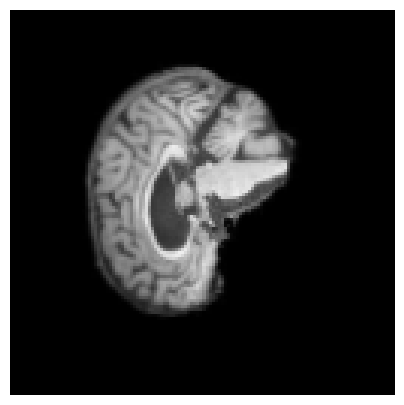

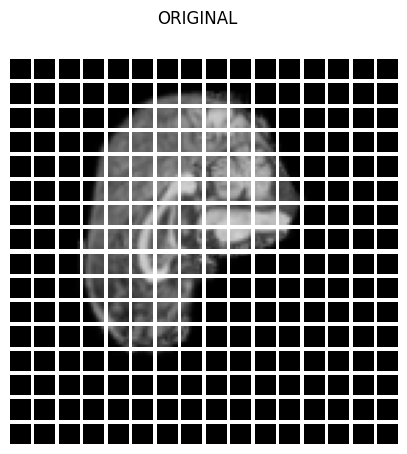

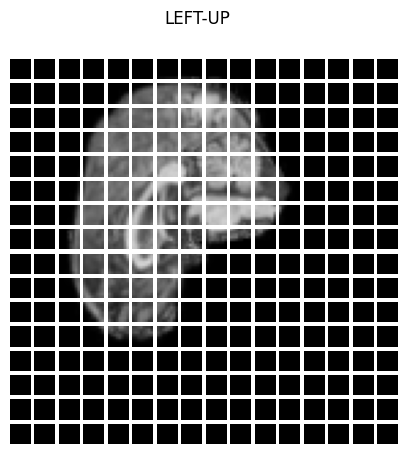

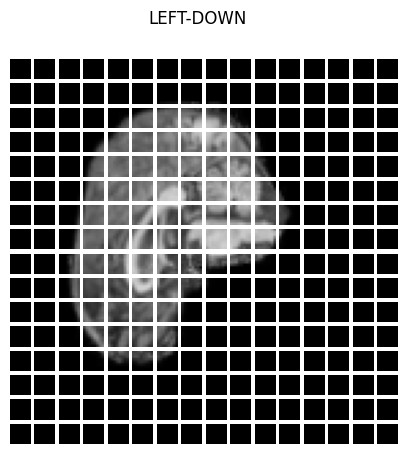

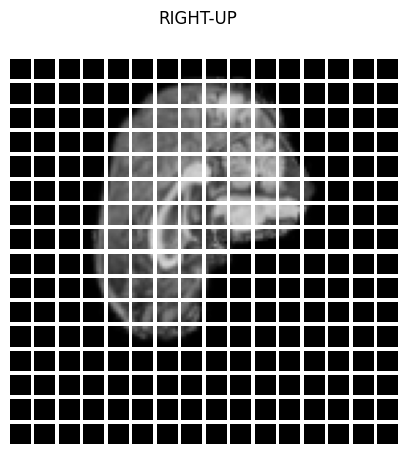

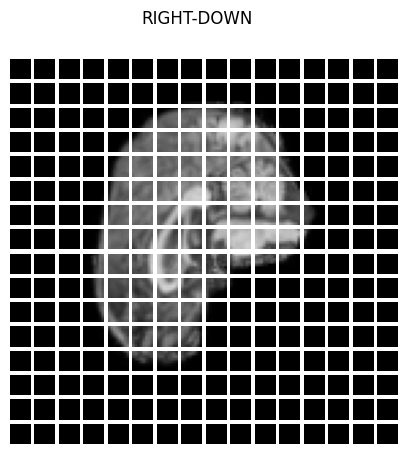

In [ ]:
def plot_image(dataset):
    """
    Ploting image from the given dataset.
    """
    plt.figure(figsize=(5, 5))
    datasetIt = dataset.__iter__()
    image = datasetIt.next()[0][0]
    plt.imshow(image.numpy().astype('uint8'))
    plt.axis('off')
    plt.show()


def plot_patches(dataset):
    """
    Ploting image from the given dataset after applying Patch_Layer to it.
    """
    datasetIt = dataset.__iter__()
    image = datasetIt.next()[0][0]

    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(IMG_SIZE, IMG_SIZE)
    )

    (token, patch) = PatchLayer(IMG_SIZE, PATCH_SIZE, NUM_PATCHES, PROJECTION_DIM)(resized_image/255.0)
    (token, patch) = (token[0], patch[0])
    n = patch.shape[0]
    shiftedImg = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]

    for index, name in enumerate(shiftedImg):
        count = 1
        plt.figure(figsize=(5, 5))
        plt.suptitle(name)

        for row in range(n):
            for col in range(n):
                plt.subplot(n, n, count)
                count = count + 1
                image= tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3 * 5))
                plt.imshow(image[..., 3 * index : 3 * index + 3])
                plt.axis('off')

    plt.show()


if __name__ == '__main__':
    train, val, test = loadData()
    plot_image(train)
    plot_patches(train)

MODEL 3

In [ ]:
# Hyperparameters
IMG_SIZE = 128
PATCH_SIZE = 8
BATCH_SIZE = 32
EPOCHS = 10
WEIGHT_DECAY = 0.0001
PROJECTION_DIM = 16 # MLP-blocks depth
LEARN_RATE = 0.0001
TRANSF_LAYERS = 1 # No. of transformer-encoder-blocks
DROPOUT_RATE = 0.3
ATTENTION_HEADS = 2
MLP_HEAD_UNITS = [16, 8]
DATA_LOAD_DEST = "/content"
MODEL_SAVE_DEST = "/content/vision_transformer"

#Calculating automat
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
HIDDEN_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
NUM_PATCHES = int((IMG_SIZE/PATCH_SIZE) ** 2)

In [ ]:
def loadData():
    """
    Loading the dataset.
    """
    trainData = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_LOAD_DEST + "/train", labels='inferred', label_mode='binary',
        image_size=[IMG_SIZE, IMG_SIZE], shuffle=True,
        batch_size=BATCH_SIZE, seed=8, class_names=['AD', 'NC']
    )

    testData = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_LOAD_DEST + "/test", labels='inferred', label_mode='binary',
        image_size=[IMG_SIZE, IMG_SIZE], shuffle=True,
        batch_size=BATCH_SIZE, seed=8, class_names=['AD', 'NC']
    )

    # Augment data
    normalize = tf.keras.layers.Normalization()
    flip = tf.keras.layers.RandomFlip(mode='horizontal', seed=8)
    rotate = tf.keras.layers.RandomRotation(factor=0.02, seed=8)
    zoom = tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1, seed=8)

    trainData = trainData.map(
        lambda x, y: (rotate(flip(zoom(normalize(x)))), y)
    )

    testData = testData.map(
        lambda x, y: (rotate(flip(zoom(normalize(x)))), y)
    )

    # Taking half of the 9000 images from the test set as validation data
    validationData = testData.take(len(list(testData))//2)

    # Using remaining images as test set
    testData = testData.skip(len(list(testData))//2)

    return trainData, validationData, testData

In [ ]:
class PatchLayer(Layer):
	"""
	Layering and transforming images into patches.
	"""
	def __init__(self, img_size, patch_size, num_patches, projection_dim, **kwargs):
		super(PatchLayer, self).__init__(**kwargs)
		self.img_size = img_size
		self.patch_size = patch_size
		self.num_patches = num_patches
		self.projection_dim = projection_dim
		self.half_patch = patch_size // 2
		self.flatten_patches = layers.Reshape((num_patches, -1))
		self.projection = layers.Dense(units=projection_dim)
		self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

	def shiftImg(self, images, mode):
		# Build diagonally shifted images
		if mode == 'left-up':
			cropheight = self.half_patch
			cropwidth = self.half_patch
			shiftheight = 0
			shiftwidth = 0
		elif mode == 'left-down':
			cropheight = 0
			cropwidth = self.half_patch
			shiftheight = self.half_patch
			shiftwidth = 0
		elif mode == 'right-up':
			cropheight = self.half_patch
			cropwidth = 0
			shiftheight = 0
			shiftwidth = self.half_patch
		else:
			cropheight = 0
			cropwidth = 0
			shiftheight = self.half_patch
			shiftwidth = self.half_patch

		crop = tf.image.crop_to_bounding_box(
			images,
			offset_height=cropheight,
			offset_width=cropwidth,
			target_height=self.img_size - self.half_patch,
			target_width=self.img_size - self.half_patch
		)

		shiftPad = tf.image.pad_to_bounding_box(
			crop,
			offset_height=shiftheight,
			offset_width=shiftwidth,
			target_height=self.img_size,
			target_width=self.img_size
		)
		return shiftPad

	def call(self, images):
		images = tf.concat(
			[
				images,
				self.shiftImg(images, mode='left-up'),
				self.shiftImg(images, mode='left-down'),
				self.shiftImg(images, mode='right-up'),
				self.shiftImg(images, mode='right-down'),
			],
			axis=-1
		)
		patches = tf.image.extract_patches(
			images=images,
			sizes=[1, self.patch_size, self.patch_size, 1],
			strides=[1, self.patch_size, self.patch_size, 1],
			rates=[1, 1, 1, 1],
			padding='VALID'
		)
		flat_patches = self.flatten_patches(patches)
		tokens = self.layer_norm(flat_patches)
		tokens = self.projection(tokens)

		return (tokens, patches)

	def getConfig_(self):
		config_ = super(PatchLayer, self).getConfig_()
		config_.update(
			{
				'img_size': self.img_size,
				'patch_size': self.patch_size,
				'num_patches': self.num_patches,
				'projection_dim': self.projection_dim
			}
		)
		return config_

In [ ]:
class Embed_Patch(Layer):
	"""
	Layer for projecting patches into a vector.
	"""
	def __init__(self, num_patches, projection_dim, **kwargs):
		super(Embed_Patch, self).__init__(**kwargs)
		self.num_patches = num_patches
		self.projection_dim = projection_dim
		self.position_embedding = layers.Embedding(
			input_dim=self.num_patches, output_dim=projection_dim
		)

	def call(self, patches):
		positions = tf.range(0, self.num_patches, delta=1)
		return patches + self.position_embedding(positions)

	def getConfig_(self):
		config_ = super(Embed_Patch, self).getConfig_()
		config_.update(
			{
				'num_patches': self.num_patches,
				'projection_dim': self.projection_dim
			}
		)
		return config_

In [ ]:
class Multi_Head_AttentionLSA(layers.MultiHeadAttention):
	"""
	Multi Head Attention layer for the transformer-encoder-block, but with the
	addition of using Local-Self-Attention to improve feature
	learning.
	"""
	def __init__(self, **kwargs):
		super(Multi_Head_AttentionLSA, self).__init__(**kwargs)
		self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

	def computeAttention(self, query, key, value, attention_mask=None,
			training=None):
		query = tf.multiply(query, 1.0/self.tau)
		attention_scores = tf.einsum(self._dot_product_equation, key, query)
		attention_mask = tf.convert_to_tensor(attention_mask)
		attention_scores = self._masked_softmax(attention_scores, attention_mask)
		attention_scores_dropout = self._dropout_layer(
			attention_scores, training=training
		)
		attention_output = tf.einsum(
			self._combine_equation, attention_scores_dropout, value
		)
		return attention_output, attention_scores

	def getConfig_(self):
		config_ = super(Multi_Head_AttentionLSA, self).getConfig_()
		return config_


def buildVisionTransformer(input_shape, img_size, patch_size, num_patches,
			attention_heads, projection_dim, hidden_units, dropout_rate,
			transf_layers, mlp_head_units):
	"""
	Building the vision transformer.
	"""
	# Input layer
	inputs = layers.Input(shape=input_shape)

	# Convert image data into patches
	(tokens, _) = PatchLayer(
		img_size,
		patch_size,
		num_patches,
		projection_dim
	)(inputs)

	# Encode patches
	encodedPatches = Embed_Patch(num_patches, projection_dim)(tokens)

	# Create transformer layers
	for _ in range(transf_layers):
		# First layer normalisation
		layerNorm1 = layers.LayerNormalization(
			epsilon=1e-6
		)(encodedPatches)

		# Build diagoanl attention mask
		diagAttnMask = 1 - tf.eye(num_patches)
		diagAttnMask = tf.cast([diagAttnMask], dtype=tf.int8)

		# Multi-head attention layer
		attention_output = Multi_Head_AttentionLSA(
			num_heads=attention_heads, key_dim=projection_dim,
			dropout=dropout_rate
		)(layerNorm1, layerNorm1, attention_mask=diagAttnMask)

		# First skip connection
		skip1 = layers.Add()([attention_output, encodedPatches])

		# Second layer normalisation
		layerNorm2 = layers.LayerNormalization(epsilon=1e-6)(skip1)

		# Multi-Layer Perceptron
		mlpLayer = layerNorm2
		for units in hidden_units:
			mlpLayer = layers.Dense(units, activation=tf.nn.gelu)(mlpLayer)
			mlpLayer = layers.Dropout(dropout_rate)(mlpLayer, training=False)

		# Second skip connection
		encodedPatches = layers.Add()([mlpLayer, skip1])

	# Create a [batch_size, projection_dim] tensor
	representtn = layers.LayerNormalization(epsilon=1e-6)(encodedPatches)
	representtn = layers.Flatten()(representtn)
	representtn = layers.Dropout(dropout_rate)(representtn, training=False)

	# MLP layer for learning features
	features = representtn
	for units in mlp_head_units:
		features = layers.Dense(units, activation=tf.nn.gelu)(features)
		features = layers.Dropout(dropout_rate)(features, training=False)

	# Classify outputs
	logits = layers.Dense(1)(features)

	# Create Keras model
	model = tf.keras.Model(inputs=inputs, outputs=logits)

	return model


In [ ]:
def compileModel():
    """
    compiles the model.
    """
    # Build and compile model
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARN_RATE,
        weight_decay=WEIGHT_DECAY
    )

    model = buildVisionTransformer(
        INPUT_SHAPE,
        IMG_SIZE,
        PATCH_SIZE,
        NUM_PATCHES,
        ATTENTION_HEADS,
        PROJECTION_DIM,
        HIDDEN_UNITS,
        DROPOUT_RATE,
        TRANSF_LAYERS,
        MLP_HEAD_UNITS
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy')
        ]
    )

    return model


def trainModel(model, trainData, val_data):
    """
    Trains and saves the model.
    """

    # Train model
    history = model.fit(
        x=trainData,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_data
    )

    # Save model
    model.save(
        MODEL_SAVE_DEST,
        overwrite=True,
        include_optimizer=True,
        save_format='tf'
    )

    # Plot and save accuracy curves
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.suptitle('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.savefig('accuracy.png')
    plt.clf()

    # Plot and save loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.suptitle('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.savefig('losses.png')
    plt.clf()


if __name__ == '__main__':
    # Load data
    train, val, test = loadData()

    # Compile and train model
    model = compileModel()
    print(model.summary())
    trainModel(model, train, val)

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 patch_layer_3 (PatchLayer)  ((None, 256, 16),            17296     ['input_3[0][0]']             
                              (None, 16, 16, 960))                                                
                                                                                                  
 embed__patch_2 (Embed_Patc  (None, 256, 16)              4096      ['patch_layer_3[0][0]']       
 h)                                                                                               
         

673/673 [==============================] - 126s 183ms/step - loss: 0.6638 - accuracy: 0.5546 - val_loss: 0.7267 - val_accuracy: 0.5208
Epoch 2/10
673/673 [==============================] - 124s 185ms/step - loss: 0.6232 - accuracy: 0.6208 - val_loss: 0.7103 - val_accuracy: 0.5341
Epoch 3/10
673/673 [==============================] - 121s 180ms/step - loss: 0.5988 - accuracy: 0.6488 - val_loss: 0.6996 - val_accuracy: 0.5317
Epoch 4/10
673/673 [==============================] - 122s 182ms/step - loss: 0.5848 - accuracy: 0.6643 - val_loss: 0.7071 - val_accuracy: 0.5709
Epoch 5/10
673/673 [==============================] - 123s 182ms/step - loss: 0.5743 - accuracy: 0.6705 - val_loss: 0.7020 - val_accuracy: 0.5561
Epoch 6/10
673/673 [==============================] - 129s 192ms/step - loss: 0.5652 - accuracy: 0.6848 - val_loss: 0.7034 - val_accuracy: 0.5667
Epoch 7/10
673/673 [==============================] - 123s 182ms/step - loss: 0.5551 - accuracy: 0.6919 - val_loss: 0.7035 - val_accura

<Figure size 640x480 with 0 Axes>

In [ ]:
def predict(load_path, testData):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARN_RATE,
        weight_decay=WEIGHT_DECAY
    )

    model = tf.keras.models.load_model(
        load_path,
        custom_objects={
            'PatchLayer': PatchLayer,
            'Embed_Patch': Embed_Patch,
            'MultiheadattentionLSA': Multi_Head_AttentionLSA,
            'AdamW': optimizer
        }
    )

    model.evaluate(testData)

    # Plot confusion matrix
    y_true = []
    y_pred = []

    for image_batch, label_batch in testData:
        y_true.append(label_batch)
        y_pred.append((model.predict(image_batch, verbose=0) > 0.5).astype('int32'))

    labels_true = tf.concat([tf.cast(item[0], tf.int32) for item in y_true], axis=0)
    labels_pred = tf.concat([item[0] for item in y_pred], axis=0)

    matrix = tf.math.confusion_matrix(labels_true, labels_pred, 2).numpy()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(x=j, y=i, s=matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actual Label', fontsize=18)
    plt.suptitle('Confusion Matrix', fontsize=18)
    plt.savefig('confusion_matrix')
    plt.clf()


if __name__ == '__main__':
    train, val, test = loadData()
    predict(MODEL_SAVE_DEST, test)

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
141/141 [==============================] - 42s 146ms/step - loss: 0.7035 - accuracy: 0.5851


<Figure size 800x800 with 0 Axes>

Found 21520 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.


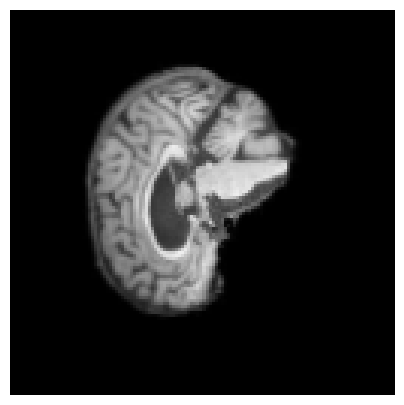

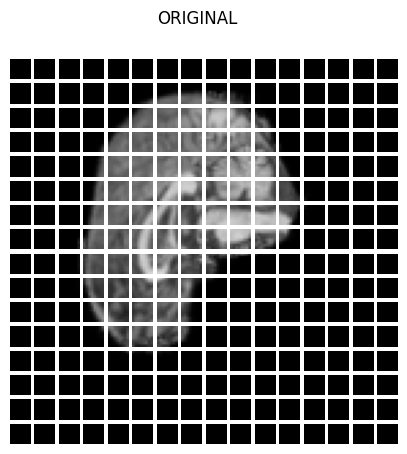

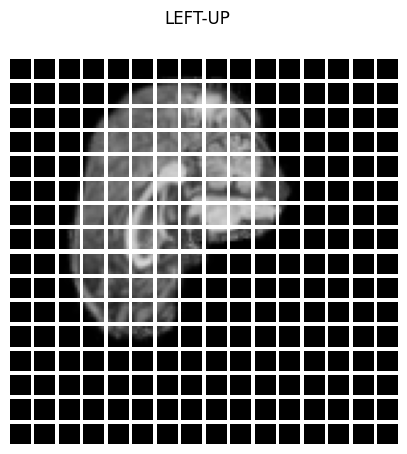

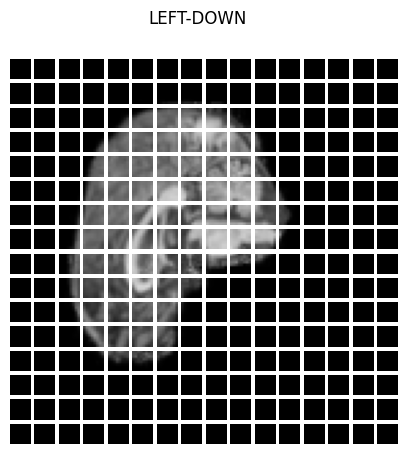

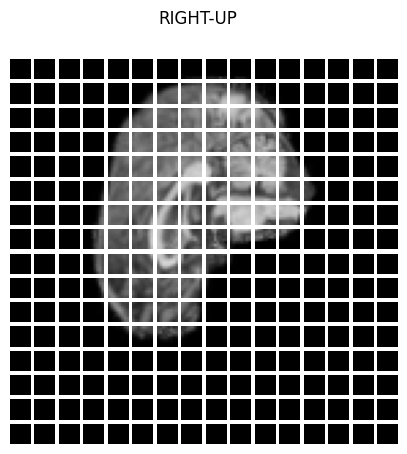

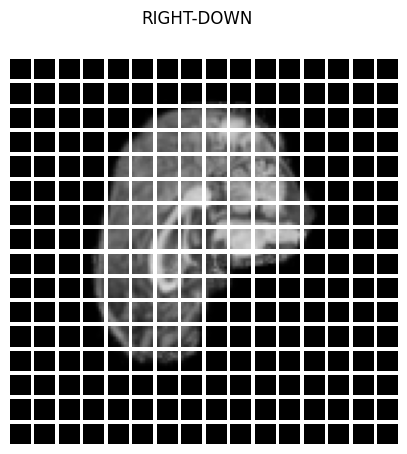

In [ ]:
def plot_image(dataset):
    """
    Ploting image from the given dataset.
    """
    plt.figure(figsize=(5, 5))
    datasetIt = dataset.__iter__()
    image = datasetIt.next()[0][0]
    plt.imshow(image.numpy().astype('uint8'))
    plt.axis('off')
    plt.show()


def plot_patches(dataset):
    """
    Ploting image from the given dataset after applying Patch_Layer to it.
    """
    datasetIt = dataset.__iter__()
    image = datasetIt.next()[0][0]

    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(IMG_SIZE, IMG_SIZE)
    )

    (token, patch) = PatchLayer(IMG_SIZE, PATCH_SIZE, NUM_PATCHES, PROJECTION_DIM)(resized_image/255.0)
    (token, patch) = (token[0], patch[0])
    n = patch.shape[0]
    shiftedImg = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]

    for index, name in enumerate(shiftedImg):
        count = 1
        plt.figure(figsize=(5, 5))
        plt.suptitle(name)

        for row in range(n):
            for col in range(n):
                plt.subplot(n, n, count)
                count = count + 1
                image= tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3 * 5))
                plt.imshow(image[..., 3 * index : 3 * index + 3])
                plt.axis('off')

    plt.show()


if __name__ == '__main__':
    train, val, test = loadData()
    plot_image(train)
    plot_patches(train)